In [106]:
#imports
%matplotlib inline
import matplotlib.pyplot as plt
import base64
import sys
import time
import pyvisa
from time import sleep
import numpy as np
from toptica.lasersdk.client import Client, SerialConnection, UserLevel
import pandas as pd

In [119]:
#set connections to DLC smart and lock-in amplifier
lockin_address = 'GPIB::8::INSTR'
dlc_connection_port = 'COM6'
#lock-in sensitivity setting
sensitivity_setting = 15
#set frequency to measure at
set_frequency = 131 #GHz
time_constant = 6 #lock-in time constant setting, specifics found in SR830 manual
low_pass_filter = 1 #lock-in low pass filter slope setting, specifics found in SR830 manual

In [73]:
#set up connection with lock-in amplifier
# Make sure the USB is plugged in before the lockin is turned on!
rm = pyvisa.ResourceManager()
lockin = rm.open_resource(lockin_address)
idn = lockin.query('*IDN?')
print(f'Connected to: {idn}')

Connected to: Stanford_Research_Systems,SR830,s/n46458,ver1.07 



In [245]:
data = {'Desired Frequency (GHz)': [], 
        'Measured Frequency (GHz)': [], 
        'Vlockin X (microvolts)': [],
        'Vlockin Y (microvolts)': [],
        'Vlockin R (microvolts)': [],
        'Vlockin Theta (degrees)': [],
        'Vlockin r (microvolts)': [],
       }

runtime = 10;
frequency = 0;
measured_frequency = 0;
t = []
t0 = time.time()
count = 0
while abs(time.time()-t0)<runtime:
    vlockin = np.zeros((5,1))
    tloop = time.time()
    while np.abs(time.time()-tloop)<0.5:
        v = lockin.query('SNAP?1,2,3,4').split(',')
        v = [float(vi) for vi in v]
        v.append(float(v[0]*np.cos(v[3]*np.pi/180)+v[1]*np.sin(v[3]*np.pi/180)))
        vlockin = np.concatenate((vlockin, np.array(v).reshape(-1,1)),axis=1)
    
    vlockin = np.median(vlockin[::,1::],axis=1)
    data['Desired Frequency (GHz)'].append(frequency)
    data['Measured Frequency (GHz)'].append(measured_frequency)
    data['Vlockin X (microvolts)'].append(float(vlockin[0]*1e5))
    data['Vlockin Y (microvolts)'].append(float(vlockin[1]*1e5))
    data['Vlockin R (microvolts)'].append(float(vlockin[2]*1e5))
    data['Vlockin Theta (degrees)'].append(float(vlockin[3]))
    data['Vlockin r (microvolts)'].append(float(vlockin[4]*1e5))

df = pd.DataFrame(data)
print(df.median(axis=0))
print(np.std(df,axis=0)/np.median(df,axis=0))

C:\Users\jcornelison\AppData\Local\anaconda3\envs\PROWLS_work\Lib\site-packages\pyvisa\resources\messagebased.py:647: UserWarning: read string doesn't end with termination characters
  return self.read()


Desired Frequency (GHz)      0.000000
Measured Frequency (GHz)     0.000000
Vlockin X (microvolts)      -0.006706
Vlockin Y (microvolts)       0.008196
Vlockin R (microvolts)       0.083447
Vlockin Theta (degrees)     16.356000
Vlockin r (microvolts)       0.089174
dtype: float64
Desired Frequency (GHz)          NaN
Measured Frequency (GHz)         NaN
Vlockin X (microvolts)     -3.879040
Vlockin Y (microvolts)      2.795563
Vlockin R (microvolts)      0.114426
Vlockin Theta (degrees)     2.836097
Vlockin r (microvolts)      0.117212
dtype: float64


In [243]:
df = pd.DataFrame(data)
print(df.median(axis=0))
print(np.std(df,axis=0)/np.median(df,axis=0))

Desired Frequency (GHz)     0.000000e+00
Measured Frequency (GHz)    0.000000e+00
Vlockin X (microvolts)      8.349910e-05
Vlockin Y (microvolts)      1.490130e-08
Vlockin R (microvolts)      8.335010e-05
Vlockin Theta (degrees)     6.000000e-03
Vlockin r (microvolts)      8.349964e-05
dtype: float64
Desired Frequency (GHz)           NaN
Measured Frequency (GHz)          NaN
Vlockin X (microvolts)       0.007369
Vlockin Y (microvolts)      17.975344
Vlockin R (microvolts)       0.007400
Vlockin Theta (degrees)     33.086640
Vlockin r (microvolts)       0.007373
dtype: float64


In [16]:
#set up connection with DLC smart and check user level
with Client(SerialConnection(dlc_connection_port)) as client:
    user_level = client.get('ul')
    dlc_smart = client.get('general:system-type')
    print(f"Connected to: {dlc_smart}")
    print(f"Current User Level: {user_level}")

Connected to: DLCsmartTHz
Current User Level: 3


In [5]:
#turn on lasers (check emission lights)
#if lasers do not power on, check the frontkey and user level
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('laser-operation:emission-global-enable', True)
    laser_on_status = client.get('laser-operation:emission-global-enable')
    print(f'Lasers on: {laser_on_status}')
#wait 5 secs for lasers to adjust
time.sleep(5)

Lasers on: True


In [17]:
#set DLC Smart bias amplitude and offset to default
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 0.80)
    client.set('lockin:mod-out-offset', -0.30)
#set DLC Smart bias frequency to 1000
    client.set('lockin:frequency', 1000)
    print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    print(f"Current DLC Smart Bias Frequency (Hz): {client.get('lockin:frequency')}")
#wait 5 secs for DLC smart to adjust
time.sleep(5)

Current DLC Smart Bias Amplitude (V): 0.800018310546875
Current DLC Smart Bias Offset (V): -0.30002441704309607
Current DLC Smart Bias Frequency (Hz): 1000


In [18]:
#set DLC Smart frequency to value you wish to measure
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    print(f"Current DLC Smart Frequency (GHz): {client.get('frequency:frequency-act')}")

Current DLC Smart Frequency (GHz): 60.00322088319808


In [13]:
#set lock-in amplifier sensitivity
lockin.write(f'SENS {sensitivity_setting}')
lockin_sensitivity = lockin.query('SENS?')
print(f"Current Lock-in Sensitivity setting: {lockin_sensitivity}")
#set lock-in time constant setting
lockin.write(f'OFLT {time_constant}')
print(f"Current Time Constant: {lockin.query('OFLT?')}")
#set lock-in low pass filter slope
lockin.write(f'OFSL {low_pass_filter}')
print(f"Current Low Pass Filter: {lockin.query('OFSL?')}")

Current Lock-in Sensitivity setting: 15

Current Time Constant: 6

Current Low Pass Filter: 1



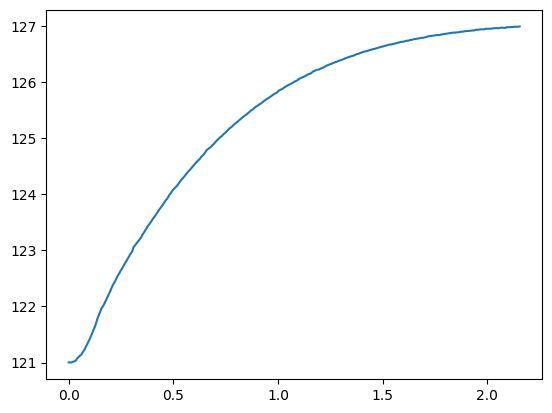

In [54]:
# See how long it takes to move to a new frequency
set_frequency = 127
frequency_tolerance = 0.01
t = []
f = []

with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    measured_frequency = client.get('frequency:frequency-act')
    #loop until the measured frequency is close to the desired frequency
    tstart = time.time()
    while abs(measured_frequency - set_frequency) > frequency_tolerance:
        #get actual frequency from DLC Smart
        t.append(time.time()-tstart)
        measured_frequency = client.get('frequency:frequency-act')
        f.append(measured_frequency)

plt.figure(1)
plt.plot(t,f)
plt.show()

In [57]:
# See if there's a dependence on freq vs amplitude
set_frequency = 127 # Really good dV/dF here.
frequency_tolerance = 0.01
t = []
f = []
v = []
with Client(SerialConnection(dlc_connection_port)) as client:
    #client.set('frequency:frequency-set', set_frequency)
    #measured_frequency = client.get('frequency:frequency-act')
    #loop until the measured frequency is close to the desired frequency
    tstart = time.time()
    while abs(time.time()-tstart) < 60:
        #get actual frequency from DLC Smart
        t.append(time.time()-tstart)
        measured_frequency = client.get('frequency:frequency-act')
        f.append(measured_frequency)
        v.append(float(lockin.query('OUTP?3')) * 1e6)



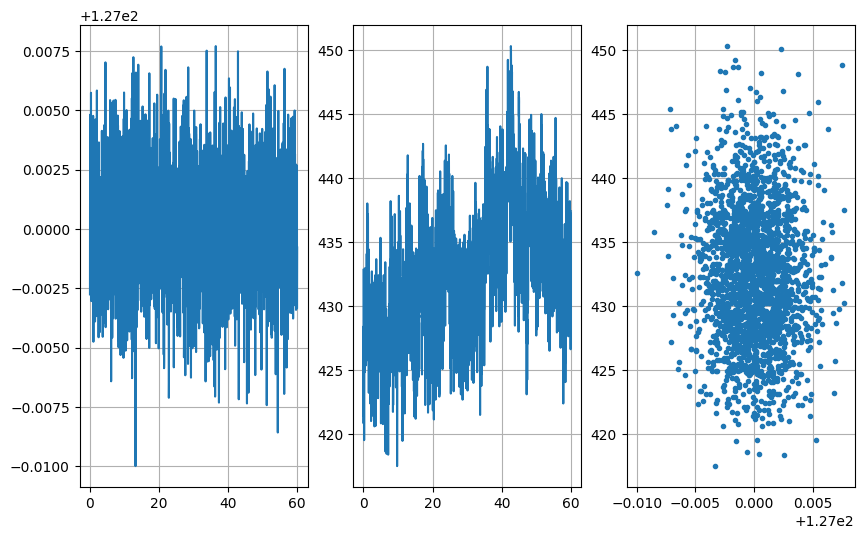

In [58]:
plt.figure(2,figsize = (10, 6))
plt.subplot(1,3,1)
plt.plot(t,f)
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(t,v)
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(f,v,'.')
plt.grid(True)

plt.show()

In [15]:
# Try to a rapid scan

set_frequency = 300
frequency_tolerance = 1
t = []
f = []
v = []

with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    measured_frequency = client.get('frequency:frequency-act')
    #loop until the measured frequency is close to the desired frequency
    tstart = time.time()
    while abs(measured_frequency - set_frequency) > frequency_tolerance:
        #get actual frequency from DLC Smart
        #t.append(time.time()-tstart)
        measured_frequency = client.get('frequency:frequency-act')
        f.append(measured_frequency)
        v.append(float(lockin.query('OUTP?3')) * 1e6)

set_frequency = 60
frequency_tolerance = 1
#t = []
f2 = []
v2 = []

with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    measured_frequency = client.get('frequency:frequency-act')
    #loop until the measured frequency is close to the desired frequency
    tstart = time.time()
    while abs(measured_frequency - set_frequency) > frequency_tolerance:
        #get actual frequency from DLC Smart
        #t.append(time.time()-tstart)
        measured_frequency = client.get('frequency:frequency-act')
        f2.append(measured_frequency)
        v2.append(float(lockin.query('OUTP?3')) * 1e6)




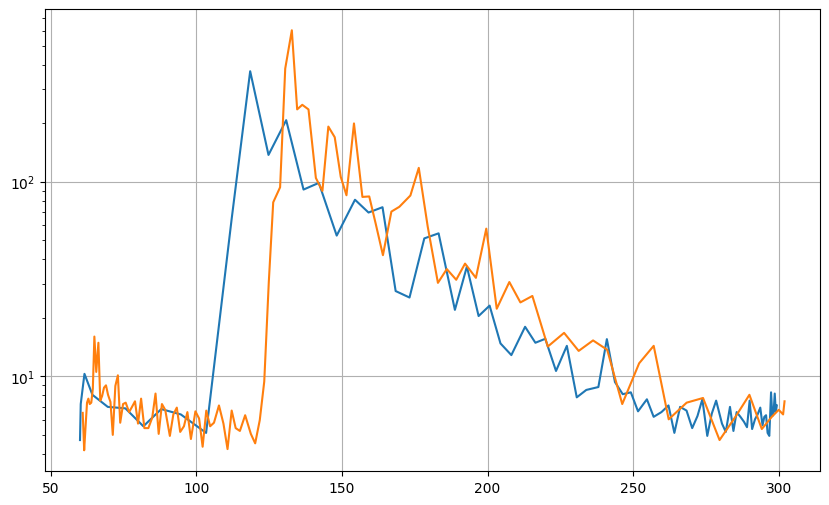

In [16]:
plt.figure(3,figsize=(10,6))
plt.plot(f,v)
plt.plot(f2,v2)
plt.yscale('log')
plt.grid(True)
plt.show()

In [6]:
import serial.tools.list_ports

# List all available COM ports
ports = list(serial.tools.list_ports.comports())

# Print information about each port
for port in ports:
    print(f"Device: {port.device}")
    print(f"  Name: {port.name}")
    print(f"  Description: {port.description}")
    print(f"  Hardware ID: {port.hwid}")
    print()
    

Device: COM4
  Name: COM4
  Description: Standard Serial over Bluetooth link (COM4)
  Hardware ID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_VID&0001005D_PID&223B\7&27F41FB4&0&000A451A1016_C00000000

Device: COM3
  Name: COM3
  Description: Standard Serial over Bluetooth link (COM3)
  Hardware ID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\7&27F41FB4&0&000000000000_00000000

Device: COM9
  Name: COM9
  Description: USB Serial Device (COM9)
  Hardware ID: USB VID:PID=29BA:0009 SER= LOCATION=1-4.4.4.3



In [12]:
# List all connected resources

import pyvisa
rm = pyvisa.ResourceManager()

resources = rm.list_resources()
print(resources)
# Filter out serial (COM) devices and print their information
for resource in resources:
    if True:#'ASRL' in resource:  # ASRL is the VISA prefix for serial ports
        print(f"Found Serial Device: {resource}")

        # Optional: Open resource to query further information
        try:
            instrument = rm.open_resource(resource)
            print(f"  COM Port: {resource}")
            # You can also query more information if the device supports it
            #idn = instrument.query('*IDN?')
            idn = instrument.query('*IDN?')
            print(f"  Device ID: {idn}")
            instrument.close()
        except Exception as e:
            print(f"  Could not query the device: {e}")

# Close the resource manager
#rm.close()
#instrument = rm.open_resource(resources[0])
rm.close()

('ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL10::INSTR', 'GPIB0::4::INSTR', 'GPIB0::8::INSTR')
Found Serial Device: ASRL3::INSTR
  COM Port: ASRL3::INSTR
  Could not query the device: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
Found Serial Device: ASRL4::INSTR
  Could not query the device: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).
Found Serial Device: ASRL5::INSTR
  COM Port: ASRL5::INSTR
  Device ID: *IDN?

Found Serial Device: ASRL10::INSTR
  Could not query the device: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).
Found Serial Device: GPIB0::4::INSTR
  COM Port: GPIB0::4::INSTR
  Device ID: Agilent Technologies,E3647A,0,2.4-6.1-2.1

Found Serial Device: GPIB0::8::INSTR
  COM Port: GPIB0::8::INSTR
  Device ID: Stanford_Research_Systems,SR830,s/n46458,ver1.07 



In [74]:
#set DLC Smart bias amplitude and offset to default
#t = []
f = []
v = []
offsets = np.arange(-0.9,0.6,0.1)
vsets = np.arange(0,1.5,0.1)
v = np.zeros((len(offsets),len(vsets)))
#plt.figure(4)
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 0.80)
    client.set('lockin:mod-out-offset', -0.30)
    #set DLC Smart bias frequency to 1000
    client.set('lockin:frequency', 1000)
    off = [];
    for offidx,offset in enumerate(offsets):
        off.append(offset)
        for vidx,vset in enumerate(vsets):
            client.set('lockin:mod-out-amplitude', vset)
            client.set('lockin:mod-out-offset', offset)
            sleep(0.05)
            #f.append(client.get('lockin:mod-out-amplitude'))
            #v.append(float(lockin.query('OUTP?3')) * 1e6)
            v[offidx,vidx] = float(lockin.query('OUTP?3')) * 1e6
        #plt.plot(f,v)
        
        
    client.set('lockin:mod-out-amplitude', 0.80)
    client.set('lockin:mod-out-offset', -0.30)

#plt.show()

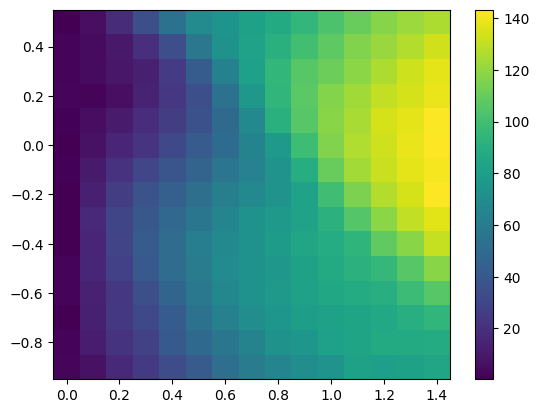

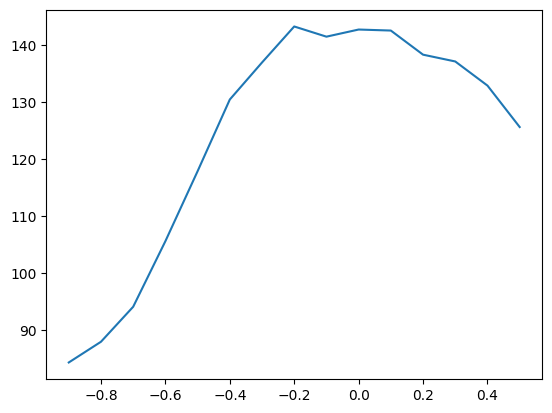

In [75]:
plt.figure(4)
plt.pcolormesh(vsets,offsets,v,shading='nearest')
plt.colorbar()
plt.show()

plt.plot(offsets,v[::,-1])
plt.show()

In [84]:
#set DLC Smart bias amplitude and offset to default
#t = []
f = []
v = []
offsets = [0]
vsets = np.arange(0,2.0,0.05)
v = np.zeros((len(offsets),len(vsets)))
#plt.figure(4)
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 0.80)
    client.set('lockin:mod-out-offset', -0.30)
    #set DLC Smart bias frequency to 1000
    client.set('lockin:frequency', 1000)
    off = [];
    for offidx,offset in enumerate(offsets):
        off.append(offset)
        for vidx,vset in enumerate(vsets):
            client.set('lockin:mod-out-amplitude', vset)
            client.set('lockin:mod-out-offset', offset)
            sleep(0.05)
            #f.append(client.get('lockin:mod-out-amplitude'))
            #v.append(float(lockin.query('OUTP?3')) * 1e6)
            v[offidx,vidx] = float(lockin.query('OUTP?3')) * 1e6
        #plt.plot(f,v)
        
        
    client.set('lockin:mod-out-amplitude', 0.80)
    client.set('lockin:mod-out-offset', -0.30)


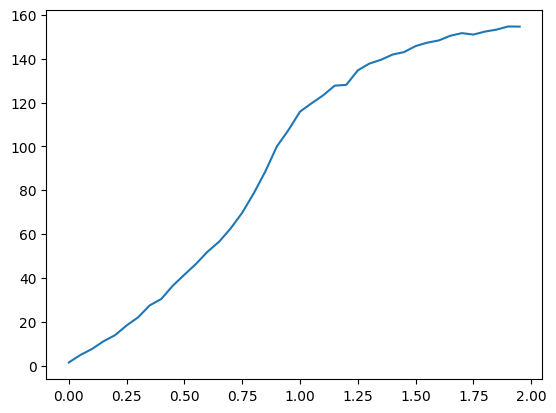

In [85]:
plt.plot(vsets,v[0,::])
plt.show()
